<a href="https://colab.research.google.com/github/RideneFiras/PI_4DATA/blob/Firas/5GDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Imports <h1>

In [ ]:
!pip install scikit-learn==1.3.2 scikeras --upgrade


  Using cached scikeras-0.13.0-py3-none-any.whl.metadata (3.1 kB)
INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import regularizers
from xgboost import XGBRegressor

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV


<h1> Loading Data <h1>


In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/ML_Project/Train.csv')
# Display shape and head
print(df.shape)
df.head()


Mounted at /content/drive
(34274, 41)


,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
1,Id_f1zf07cwb6,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2,Id_uoxdz7di5b,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0
3,Id_hzn8nj29gu,1624542066,pc1,-95.598750,-14.696250,-61.660000,10.726,95955.0,17.0,20.0,...,13.43,0.71,1017.9,1.97,0.99,3.0,16.093,8.80702,Avenue,46400000.0
4,Id_2kfrccrfiw,1624542798,pc1,-97.735000,-14.867500,-63.170625,10.889,83062.0,19.0,20.0,...,13.46,0.71,1017.9,1.97,0.99,3.0,16.093,2.21843,Park,50200000.0


In [ ]:
print("Min:", df['target'].min() / 1_000_000, "Mbit/s")
print("Max:", df['target'].max() / 1_000_000, "Mbit/s")
print("Mean:", df['target'].mean() / 1_000_000, "Mbit/s")


Min: 0.048 Mbit/s
Max: 271.0 Mbit/s
Mean: 55.5038645620587 Mbit/s


<h1> Preprocessing<h1>

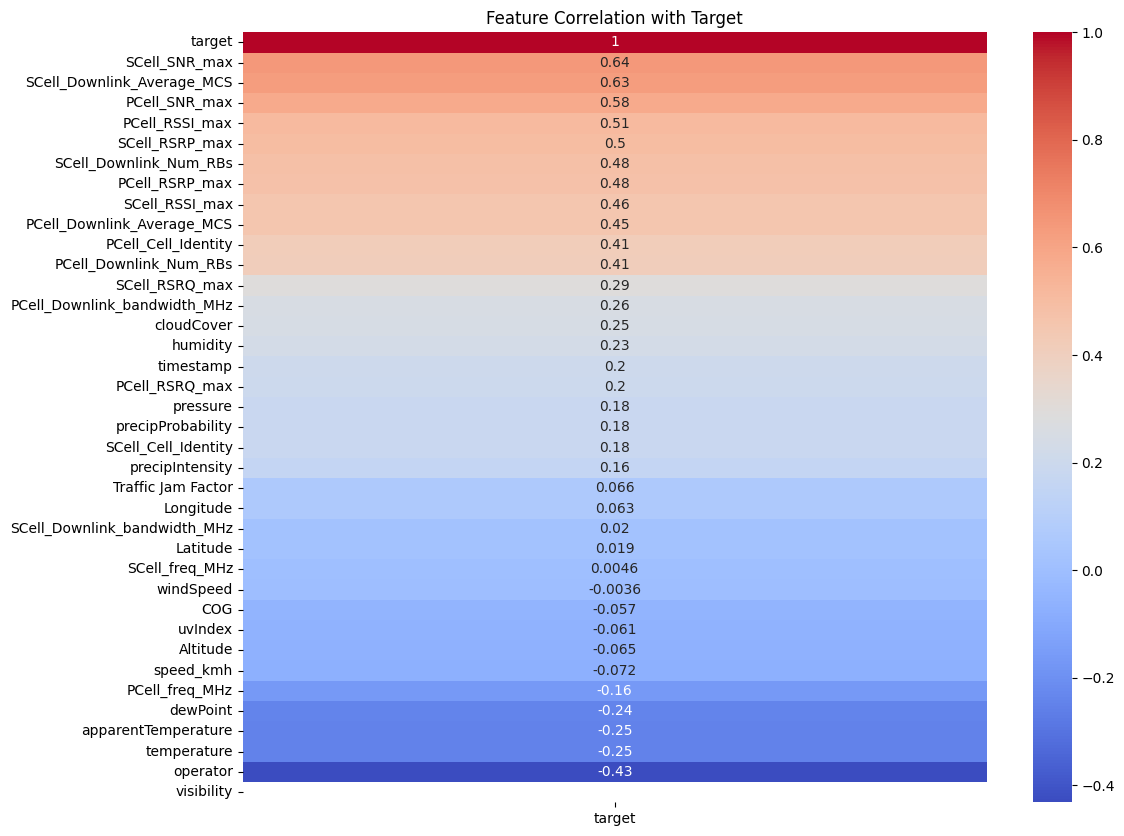

In [ ]:


corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr[['target']].sort_values('target', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target")
plt.show()


In [ ]:
# Drop irrelevant columns
df.drop(columns=['id', 'timestamp', 'device', 'area'], inplace=True)

# Add Scell_active flag
df['Scell_active'] = df['SCell_Cell_Identity'].notnull().astype(int)

# Separate Scell columns
scell_cols = [col for col in df.columns if col.startswith('SCell_')]

# Fill Scell-related features with 0
df[scell_cols] = df[scell_cols].fillna(0)

# Fill the remaining missing values (e.g. PCell, environment) with median
df = df.fillna(df.median(numeric_only=True))
df['SNR_ratio'] = df['SCell_SNR_max'] / (df['PCell_SNR_max'] + 1e-6)
df['MCS_diff'] = df['SCell_Downlink_Average_MCS'] - df['PCell_Downlink_Average_MCS']

# Prepare feature list
features = df.drop(columns=['target']).columns.tolist()
print("Shape:", df.shape)
print("Features:", features)


Shape: (34274, 40)
Features: ['PCell_RSRP_max', 'PCell_RSRQ_max', 'PCell_RSSI_max', 'PCell_SNR_max', 'PCell_Downlink_Num_RBs', 'PCell_Downlink_Average_MCS', 'PCell_Downlink_bandwidth_MHz', 'PCell_Cell_Identity', 'PCell_freq_MHz', 'SCell_RSRP_max', 'SCell_RSRQ_max', 'SCell_RSSI_max', 'SCell_SNR_max', 'SCell_Downlink_Num_RBs', 'SCell_Downlink_Average_MCS', 'SCell_Downlink_bandwidth_MHz', 'SCell_Cell_Identity', 'SCell_freq_MHz', 'operator', 'Latitude', 'Longitude', 'Altitude', 'speed_kmh', 'COG', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility', 'Traffic Jam Factor', 'Scell_active', 'SNR_ratio', 'MCS_diff']


<h1>Split and scale<h1>


In [ ]:
# 1. Features and target
X = df[features]
y = df['target']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Scale (before passing to Keras)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Build and train the neural network model


In [ ]:
# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],),
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(1)  # Output layer
])


# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Add early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4714541040533504.0000 - mae: 54100096.0000 - val_loss: 1548581462867968.0000 - val_mae: 30439954.0000
Epoch 2/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1117355539169280.0000 - mae: 25632756.0000 - val_loss: 575162491600896.0000 - val_mae: 17704518.0000
Epoch 3/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 538023104086016.0000 - mae: 16710498.0000 - val_loss: 381062987382784.0000 - val_mae: 13723590.0000
Epoch 4/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 386627553722368.0000 - mae: 13888142.0000 - val_loss: 318528330661888.0000 - val_mae: 12501469.0000
Epoch 5/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 340017260003328.0000 - mae: 12924490.0000 - val_loss: 281819580727296.0000 - val_mae: 11657483.0000
Epoch 6/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 306911954075648.0000 - mae: 12239359.0000 - val_loss: 257944276959232.0000 - val_mae: 11110148.0000
Epoch 7/100
686/686 ━━━━━━━━━━━

In [ ]:


# # Define the model
# model = XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )

# # Train the model
# model.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = model.predict(X_test)

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = np.mean(np.abs(y_test - y_pred))

# print("RMSE (Mbit/s):", rmse / 1_000_000)
# print("MAE  (Mbit/s):", mae / 1_000_000)


In [ ]:
# param_dist = {
#     'model__units_1': [64, 128, 256],
#     'model__units_2': [32, 64, 128],
#     'model__dropout_rate': [0.2, 0.3, 0.4],
#     'batch_size': [32, 64],
#     'epochs': [100]  # Capped for now, we’ll retrain best config later
# }

# random_search = RandomizedSearchCV(
#     regressor,
#     param_distributions=param_dist,
#     n_iter=5,                 # Try 5 combinations (can increase later)
#     cv=3,                     # 3-fold cross-validation
#     scoring='neg_mean_squared_error',
#     n_jobs=-1
# )

# # Start training search
# random_search.fit(X_train, y_train)


In [ ]:
# print("Best Parameters:", random_search.best_params_)

# # Predict on test set using best model
# y_pred = random_search.best_estimator_.predict(X_test).flatten()

# # Evaluate
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = np.mean(np.abs(y_test - y_pred))

# print("RMSE (Mbit/s):", rmse / 1_000_000)
# print("MAE  (Mbit/s):", mae / 1_000_000)


In [ ]:
# # Example: Retrain final model
# best_params = random_search.best_params_
# final_model = build_model(
#     units_1=best_params['model__units_1'],
#     units_2=best_params['model__units_2'],
#     dropout_rate=best_params['model__dropout_rate']
# )

# from tensorflow.keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = final_model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     epochs=300,
#     batch_size=best_params['batch_size'],
#     callbacks=[early_stop],
#     verbose=1
# )


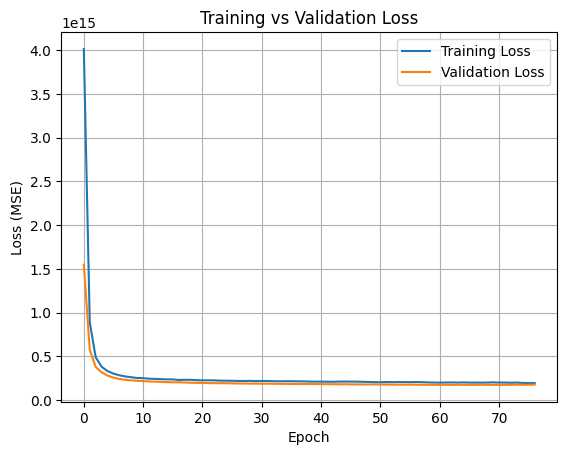

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(np.abs(y_test - y_pred))

print("RMSE (Mbit/s):", rmse / 1_000_000)
print("MAE  (Mbit/s):", mae / 1_000_000)


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE (Mbit/s): 13.554880771225035
MAE  (Mbit/s): 8.874829245733041


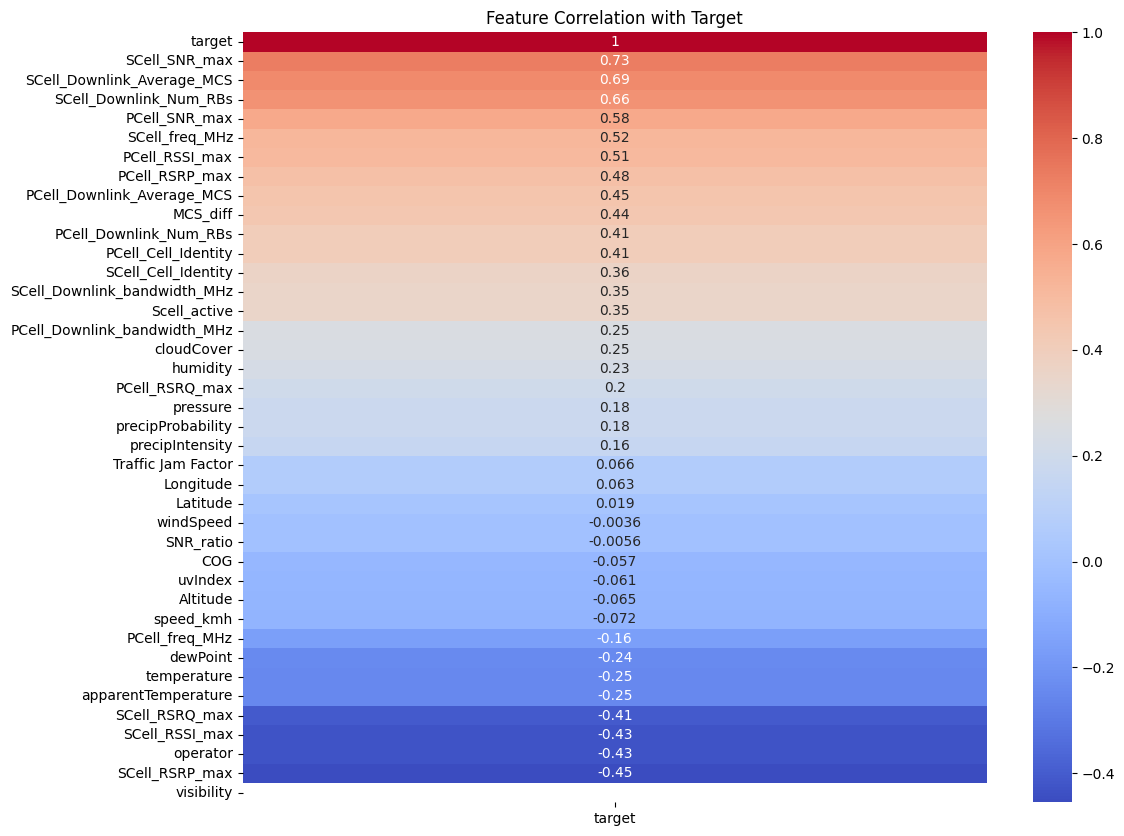

In [ ]:


corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr[['target']].sort_values('target', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target")
plt.show()
